In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
import logging
import hydra
from matplotlib import pyplot as plt
from scipy.fft import fft2
import numpy as np
import xarray
import gnss_tid.plotting
plt.style.use("bmh")

with hydra.initialize(version_base=None, config_path="src/gnss_tid/conf", job_name="jupyter"):
    cfg = hydra.compose(config_name="config")
logging.basicConfig(level=logging.INFO)
cfg.focus.n_jobs = 1
logging.info("%s", cfg.focus.n_jobs)
points = hydra.utils.instantiate(cfg.event.pointdata)
focuser = hydra.utils.instantiate(cfg.focus)


INFO:root:1


In [1]:

from matplotlib import pyplot as plt
import numpy as np
import xarray
import gnss_tid.plotting

data = xarray.open_dataset("/homes/starrgw1/code/gnss-tid/outputs/2024-12-06/22-20-41/autofocus.h5")
data

/homes/starrgw1/code/gnss-tid/src/gnss_tid/plotting.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm import autonotebook


<xarray.Dataset> Size: 129MB
Dimensions:     (x: 224, y: 148, time: 109, py: 8, px: 12, ky: 32, kx: 32, ci: 2)
Coordinates:
  * x           (x) float64 2kB -2.231e+03 -2.211e+03 ... 2.204e+03 2.224e+03
  * y           (y) float64 1kB -1.318e+03 -1.299e+03 ... 1.59e+03 1.61e+03
  * time        (time) datetime64[ns] 872B 2015-03-25T22:00:00 ... 2015-03-25...
  * kx          (kx) float64 256B 0.0 0.001563 0.003125 ... -0.003125 -0.001563
  * ky          (ky) float64 256B 0.0 0.001563 0.003125 ... -0.003125 -0.001563
  * px          (px) float64 96B -1.911e+03 -1.592e+03 ... 1.285e+03 1.605e+03
  * py          (py) float64 64B -999.7 -680.9 -362.1 ... 594.2 913.0 1.232e+03
Dimensions without coordinates: ci
Data variables:
    image       (time, y, x) float64 29MB ...
    density     (time, y, x) int32 14MB ...
    patch       (time, py, px, ky, kx) float64 86MB ...
    Fx          (time, py, px) float64 84kB ...
    Fy          (time, py, px) float64 84kB ...
    F           (time, py, px) float64 84kB ...
    height      (time) int32 436B ...
    objective   (time) float64 872B ...
    wavelength  (time) float64 872B ...
    offset      (time) float64 872B ...
    phase       (time) float32 436B ...
    center      (ci) float64 16B ...

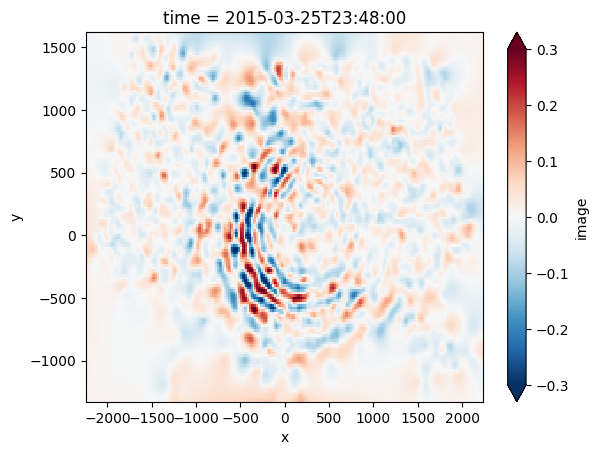

In [5]:
data.image.isel(time=data.objective.argmax("time")).plot(vmax=.3)

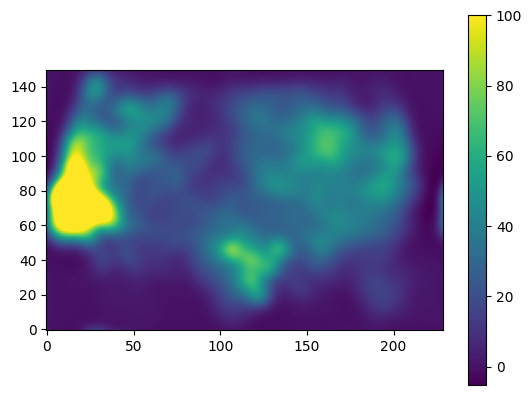

In [68]:
from sklearn.metrics import pairwise_distances
from skimage.filters import butterworth
slices, times = points.get_time_slices(cfg.sample.window, cfg.sample.step)
p = points.get_data(slices[0], 240)
DT = 100
pd = pairwise_distances(focuser.image_maker.points, np.column_stack((p.x, p.y)))
nb = pd < DT
w = nb.sum(axis=1)
w = w.reshape(focuser.image_maker.shape)
w = butterworth(w, .05, high_pass=False)

# w = np.log10(np.exp(-1 * (pd / DT) ** 2).sum(axis=1))

im = plt.imshow(w, origin="lower", vmax=100)
plt.colorbar(im)

H = nb.sum(axis=1) * data.isel(time=0).image.values.ravel()
H = H.reshape(focuser.image_maker.shape)
im = plt.imshow(H, origin="lower", vmin=-25, vmax=25, cmap="bwr")
plt.colorbar(im)